### Importing the data

In [36]:
import numpy as np 
import pandas as pd

data = pd.read_csv("data/dat1.csv", sep = ";", header=0)

n = 1000  # Number of times to repeat each row
data = data.loc[data.index.repeat(n)].reset_index(drop=True)

print(data.head())

   A  B  C  D  E  F
0  0  1  1  1  1  1
1  0  1  1  1  1  1
2  0  1  1  1  1  1
3  0  1  1  1  1  1
4  0  1  1  1  1  1


### Adding not important (noisy) features to the dataset

In [37]:
X = data.iloc[:, 1:].values  # Use .values to get only numerical array (no column headers)
y = data.iloc[:, 0].values

indices = np.random.permutation(len(X))  # Generate shuffled indices to shuffle the data
X = X[indices]  
y = y[indices]  

print('Before')
print('X', X[:5])
print('y', y[:5])

np.random.seed(1)
num_samples = len(X)
num_noise_features = 3  # Number of noise columns to add

# Add noise columns with random 1s and 0s
X_noise = np.random.randint(0, 2, size=(num_samples, num_noise_features))

# Concatenate orig features with not important columns
X = np.hstack((X, X_noise))

print('After')
print('X', X[:5])
print('y', y[:5])

Before
X [[0 0 0 0 1]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [1 0 0 1 1]
 [0 0 1 0 1]]
y [1 0 0 0 0]
After
X [[0 0 0 0 1 1 1 0]
 [1 1 1 1 1 0 1 1]
 [0 0 1 0 0 1 1 1]
 [1 0 0 1 1 0 0 1]
 [0 0 1 0 1 0 1 1]]
y [1 0 0 0 0]


### Dividing data into train/test splits

In [38]:
# Outcome column is A (the first column)
from sklearn.model_selection import train_test_split

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print('y train', X_train)
print('y test \n', y_test)

X_train shape: (25600, 8)
X_test shape: (6400, 8)
y_train shape: (25600,)
y_test shape: (6400,)
y train [[0 1 0 ... 0 1 0]
 [1 1 1 ... 0 0 1]
 [1 1 0 ... 1 0 1]
 ...
 [1 1 0 ... 1 1 1]
 [0 0 1 ... 0 1 1]
 [0 0 0 ... 1 1 0]]
y test 
 [1 1 1 ... 0 0 1]


### Using Random Forest to select most important features before Decision Tree

Feature Importances from Random Forest:
C: 0.2876
B: 0.2669
D: 0.1656
F: 0.1541
E: 0.1209
Noise_3: 0.0018
Noise_2: 0.0017
Noise_1: 0.0014
Accuracy after Feature Selection: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5253
           1       0.70      0.84      0.76      1147

    accuracy                           0.91      6400
   macro avg       0.83      0.88      0.85      6400
weighted avg       0.92      0.91      0.91      6400



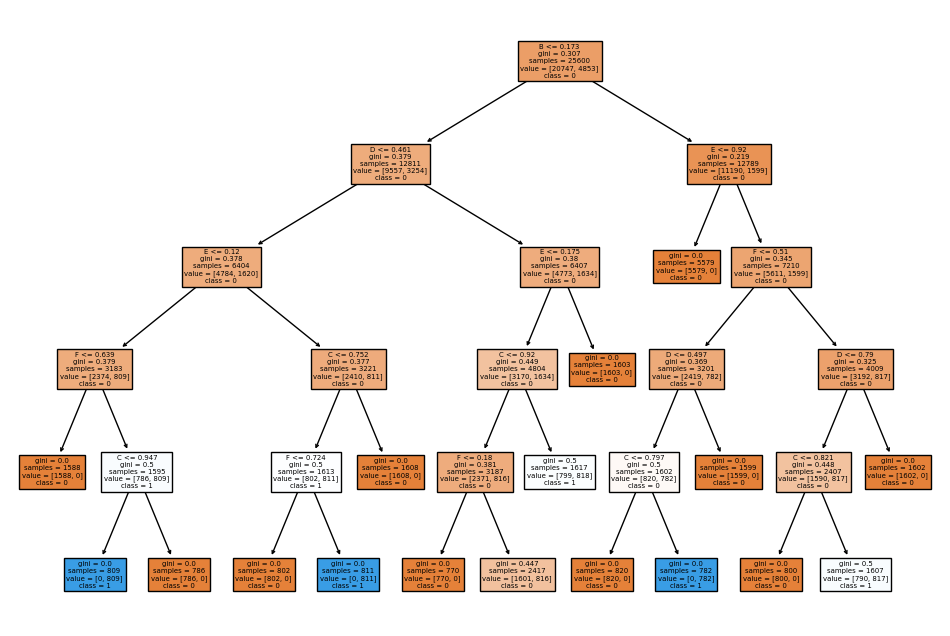

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

feature_names = ["B", "C", "D", "E", "F"]
for i in range(1, num_noise_features + 1):
    feature_names.append(f"Noise_{i}")

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
rf_classifier.fit(X_train, y_train)

# Random forest
feature_importances = rf_classifier.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Print feature importances
print("Feature Importances from Random Forest:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

# Select the msot important features
N = 5 
top_features = sorted_indices[:N]
X_train_selected = X_train[:, top_features]
X_test_selected = X_test[:, top_features]

dt_classifier = DecisionTreeClassifier(
    ccp_alpha=0.001,
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='random',
    random_state=1  
)
dt_classifier.fit(X_train_selected, y_train)

y_pred = dt_classifier.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after Feature Selection: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))

# Visualize
plt.figure(figsize=(12, 8))
selected_feature_names = [sorted_features[i] for i in range(N)]  # Get names of selected features
plot_tree(dt_classifier, filled=True, feature_names=selected_feature_names, class_names=["0", "1"])
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV

dt_new = DecisionTreeClassifier(random_state=1)

# Hyperparam grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(dt_new, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
